In [22]:
import pandas as pd
import seaborn as sns
import new_lib as nl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import acquire
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [23]:
def data(df):
    df = acquire.get_telco_data(nl.get_db_url)
    df = df.iloc[:, 1:]
    df = df.drop(['gender', 'senior_citizen', 'partner', 'phone_service', 'tech_support', 'streaming_tv', 
                    'streaming_movies', 'paperless_billing', 'internet_service_type', 'online_security', 'online_backup', 
                    'device_protection', 'internet_service_type_id', 'customer_id', 'multiple_lines'], axis =1)
    df = df.dropna()
    df.total_charges = df.total_charges.replace(' ', 0).astype(float)
    
    return df

In [24]:
telco = data('df')

In [25]:
def chi2(parameter, df):
    chi2, p, degf, expected = chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(df.churn, df[parameter]))
    if p <= .05:
        print(f'Comparing relationship between churn and {parameter}')
        print(chi2, p)
        print('------------------')
        print('\n')
        
# Using a chi2 test to determine the main drivers behind the churn at Telco 
# Does not include payments yet, have to drop na and make a seperate test below

In [26]:
chi2('dependents', telco)

Comparing relationship between churn and dependents
189.12924940423474 4.9249216612154196e-43
------------------




In [27]:
def t_test(parameter, df):
    churn = df[df.churn == 'Yes'][parameter]
    not_churned = df[df.churn == 'No'][parameter]
    t, p = stats.ttest_ind(churn, not_churned, equal_var = False)
    print(f'Comparing relationship between churn and {parameter}')
    print(t, p)
    print('------------------')
    print('\n')
# T test for the charges because they we are comparing a catagorical variable to a continuous one
# The code will print the results in a similar format to the chi2 test above

In [28]:
t_test('monthly_charges', telco)

Comparing relationship between churn and monthly_charges
18.407526676414673 8.59244933154705e-73
------------------




In [29]:
def data_split(df, target):
    train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test= nl.train_vailidate_test_split(df, target)
    
    return train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test
# Creating splits for the data using custom libraray function

In [30]:
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = data_split(telco, 'churn')

In [31]:
train.head()

,payment_type_id,contract_type_id,dependents,tenure,monthly_charges,total_charges,churn,contract_type,payment_type
1320,2,1,No,1,20.40,20.40,Yes,Month-to-month,Mailed check
6590,2,1,No,4,20.70,73.05,No,Month-to-month,Mailed check
3490,3,1,No,28,59.55,1646.45,No,Month-to-month,Bank transfer (automatic)
4745,3,3,Yes,60,20.95,1270.55,No,Two year,Bank transfer (automatic)
3268,4,3,No,63,79.85,4861.45,No,Two year,Credit card (automatic)


In [32]:
def contract_plot(df, x, hue):
    sns.countplot(x = df[x], hue = df[hue])
# Creating a count plot for contract_type hued by churn to visualize churn by each contract type

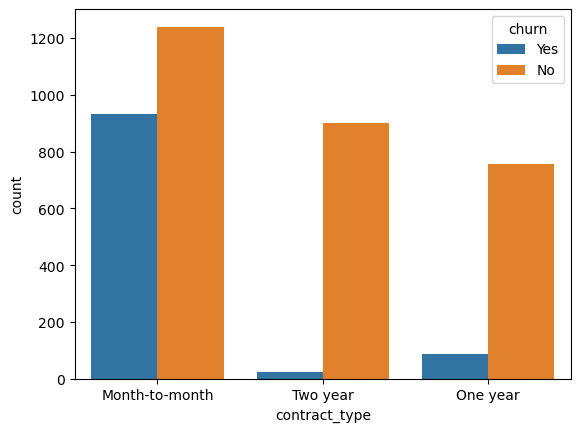

In [33]:
contract_plot(train, 'contract_type', 'churn')

In [34]:
def payment_plot(df, y, hue):
    sns.countplot(y = df[y], hue = df[hue])
#Count Plot that visualizes payment_type and the count of churn within each type of payment

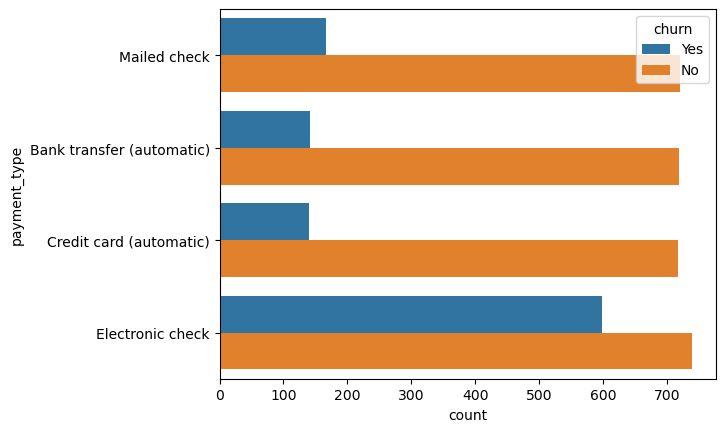

In [35]:
payment_plot(train, 'payment_type', 'churn')

In [36]:
def dependents_plot(df, x, hue):
    sns.countplot(x = df[x], hue = df[hue])
# Countplot for dependents

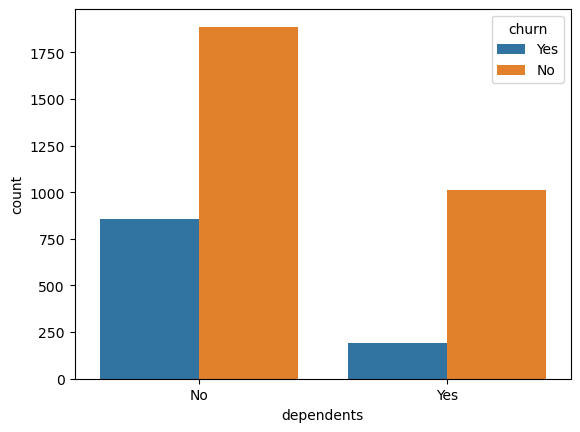

In [37]:
dependents_plot(train, 'dependents', 'churn')

In [38]:
def hist_plot(df, target, parameter, color1, color2, alpha1, alpha2, edgecolor, label1, label2, xlabel, ylabel, title):
    yes_churn = df[df[target] == 'Yes'][parameter]
    no_churn = df[df[target] =='No'][parameter]
    plt.hist(x = yes_churn, color = color1, alpha = alpha1, edgecolor = edgecolor, label = label1)
    plt.hist(x = no_churn, color = color2, alpha = alpha2, edgecolor = edgecolor, label = label2)
    plt.legend(loc = 'upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
# Creating two histograms to overlay on each other using monthly charges
# Seperated by churn status
# Originally tried to do in seaborn but cann only do using matplot

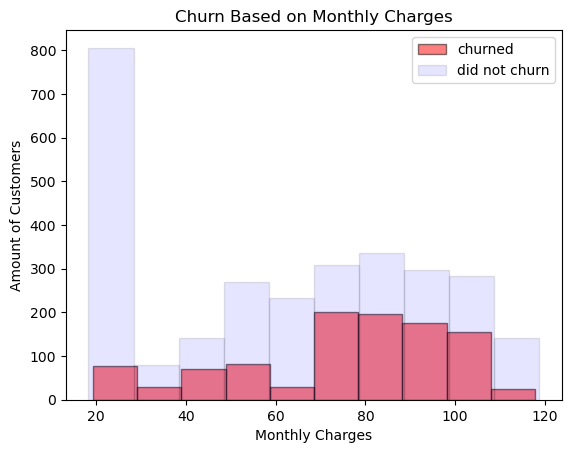

In [39]:
hist_plot(train, 'churn', 'monthly_charges', 'red', 'blue', 
          .5, .1, 'black', 'churned', 'did not churn', 'Monthly Charges', 'Amount of Customers', 'Churn Based on Monthly Charges')

In [40]:
def make_binary(df, parameter):
    df[parameter] = np.where(df[parameter] == 'Yes', 1, 0)

In [41]:
make_binary(telco, 'dependents')

In [42]:
def drop_cols(df, drop1, drop2, ax):
    df = df.drop([drop1, drop2], axis = ax)
    return df

In [43]:
telco2 = drop_cols(telco, 'contract_type', 'payment_type', 1)

In [44]:
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = data_split(telco2, 'churn')

In [45]:
def baseline(df, target):
    baseline = len(df[df[target] == 'No'])/ len(df)
    return baseline

In [46]:
baseline(telco, 'churn')

0.7346301292063041

In [47]:
X_train

,payment_type_id,contract_type_id,dependents,tenure,monthly_charges,total_charges
1320,2,1,0,1,20.40,20.40
6590,2,1,0,4,20.70,73.05
3490,3,1,0,28,59.55,1646.45
4745,3,3,1,60,20.95,1270.55
3268,4,3,0,63,79.85,4861.45
...,...,...,...,...,...,...
4890,1,1,0,4,91.65,365.40
1831,4,1,0,41,81.30,3190.65
4341,2,1,0,1,19.75,19.75
996,1,3,0,57,95.25,5464.65


In [48]:
def dec_tree(x, y, depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=77)
    train_tree.fit(x, y)
    plt.figure(figsize=(13, 7))
    plot_tree(train_tree, feature_names=x.columns, class_names=train_tree.classes_, rounded=True)

    return train_tree

DecisionTreeClassifier(max_depth=6, random_state=77)

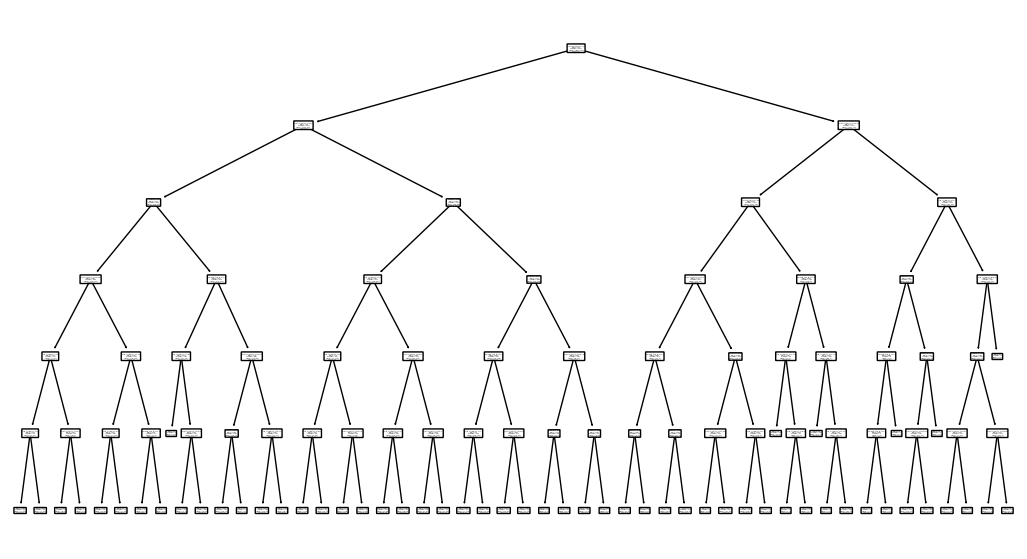

In [49]:
dec_tree(X_train, y_train, 6)

In [85]:
def tree_score(x,y,depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=77)
    train_tree.fit(X_train, y_train)
    train_tree.score(x,y)
    return train_tree.score(x,y)

In [88]:
tree_score(X_test, y_test, 7)

0.7899219304471257

In [52]:
def tree_matrix(x, y, depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=77)
    train_tree.fit(x, y)
    pred = train_tree.predict(x)
    labels = sorted(y.unique())
    df = pd.DataFrame(confusion_matrix(y, pred), index=labels, columns=labels)
    return df
    

In [77]:
tree_matrix(X_train, y_train, 6)

,No,Yes
No,2589,308
Yes,449,597


In [81]:
def tree_report(x, y, depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=77)
    train_tree.fit(x, y)
    pred = train_tree.predict(x)
    print(classification_report(y, pred))

In [82]:
tree_report(X_train, y_train, 6)

              precision    recall  f1-score   support

          No       0.85      0.89      0.87      2897
         Yes       0.66      0.57      0.61      1046

    accuracy                           0.81      3943
   macro avg       0.76      0.73      0.74      3943
weighted avg       0.80      0.81      0.80      3943



In [89]:
def ran_score(x, y, depth):
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=depth, 
                            random_state=77)
    rf.fit(X_train, y_train)
    pred = rf.predict(x)
    rf.score(x, y)
    return rf.score(x, y)


In [91]:
ran_score(X_test, y_test, 7)

0.7892122072391767

In [92]:
def ran_matrix(x, y, depth):
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=depth, 
                            random_state=77)
    rf.fit(x, y)
    pred = rf.predict(x)
    labels = sorted(y.unique())
    df = pd.DataFrame(confusion_matrix(y, pred), index=labels, columns=labels)
    return df

In [93]:
ran_matrix(X_train, y_train, 6)

,No,Yes
No,2665,232
Yes,502,544


In [69]:
def ran_report(x, y, depth):
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=depth, 
                            random_state=77)
    rf.fit(x, y)
    pred = rf.predict(x)
    print(classification_report(y, pred))

In [70]:
ran_report(X_train, y_train, 6)

              precision    recall  f1-score   support

          No       0.84      0.92      0.88      2897
         Yes       0.70      0.52      0.60      1046

    accuracy                           0.81      3943
   macro avg       0.77      0.72      0.74      3943
weighted avg       0.80      0.81      0.80      3943



In [71]:
def log_reg_score(x, y, c):
    logit = LogisticRegression(C= c, random_state=77, intercept_scaling=1, solver='lbfgs')
    logit.fit(x, y)
    pred = logit.predict(x)
    logit.score(x, y)
    return logit.score(x, y)

In [72]:
log_reg_score(X_train, y_train, 1)

0.7895003804209992

In [73]:
def log_matrix(x, y, c):
    logit = LogisticRegression(C= c, random_state=77, intercept_scaling=1, solver='lbfgs')
    logit.fit(x, y)
    pred = logit.predict(x)
    labels = sorted(y.unique())
    df = pd.DataFrame(confusion_matrix(y, pred), index=labels, columns=labels)
    return df

In [74]:
log_matrix(X_train, y_train, 1)

,No,Yes
No,2596,301
Yes,529,517


In [75]:
def log_report(x, y, c):
    logit = LogisticRegression(C= c, random_state=77, intercept_scaling=1, solver='lbfgs')
    logit.fit(x, y)
    pred = logit.predict(x)
    print(classification_report(y, pred))

In [76]:
log_report(X_train, y_train, 1)

              precision    recall  f1-score   support

          No       0.83      0.90      0.86      2897
         Yes       0.63      0.49      0.55      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.70      0.71      3943
weighted avg       0.78      0.79      0.78      3943

